# Preliminary Analysis

### Basic loading and type definitions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import pearsonr


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel('../Taller 1/datos.xlsx')

In [4]:
df['year'] = pd.to_datetime(df['year'], format = '%Y')

In [5]:
df['pais']  = df['Pais'].astype('category')
df = df.drop('Pais', axis = 1)

In [6]:
df.columns

Index(['year', 'Produccion ', 'Reservas', 'PIB', 'Oil Prices', 'pais'], dtype='object')

### 2. Change vars to logs

In [7]:
for i in ['Produccion ', 'Reservas', 'PIB', 'Oil Prices']:
    df[f'log_{i.lower().strip()}'] = df[i].apply(np.log)

In [8]:
df.rename({'log_oil prices': 'log_oil_prices'}, inplace = True, axis = 1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   year            672 non-null    datetime64[ns]
 1   Produccion      672 non-null    float64       
 2   Reservas        672 non-null    float64       
 3   PIB             672 non-null    float64       
 4   Oil Prices      672 non-null    float64       
 5   pais            672 non-null    category      
 6   log_produccion  672 non-null    float64       
 7   log_reservas    672 non-null    float64       
 8   log_pib         672 non-null    float64       
 9   log_oil_prices  672 non-null    float64       
dtypes: category(1), datetime64[ns](1), float64(8)
memory usage: 49.3 KB


### 3. Correlations

In [10]:
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.7, 0.1), xycoords=ax.transAxes)

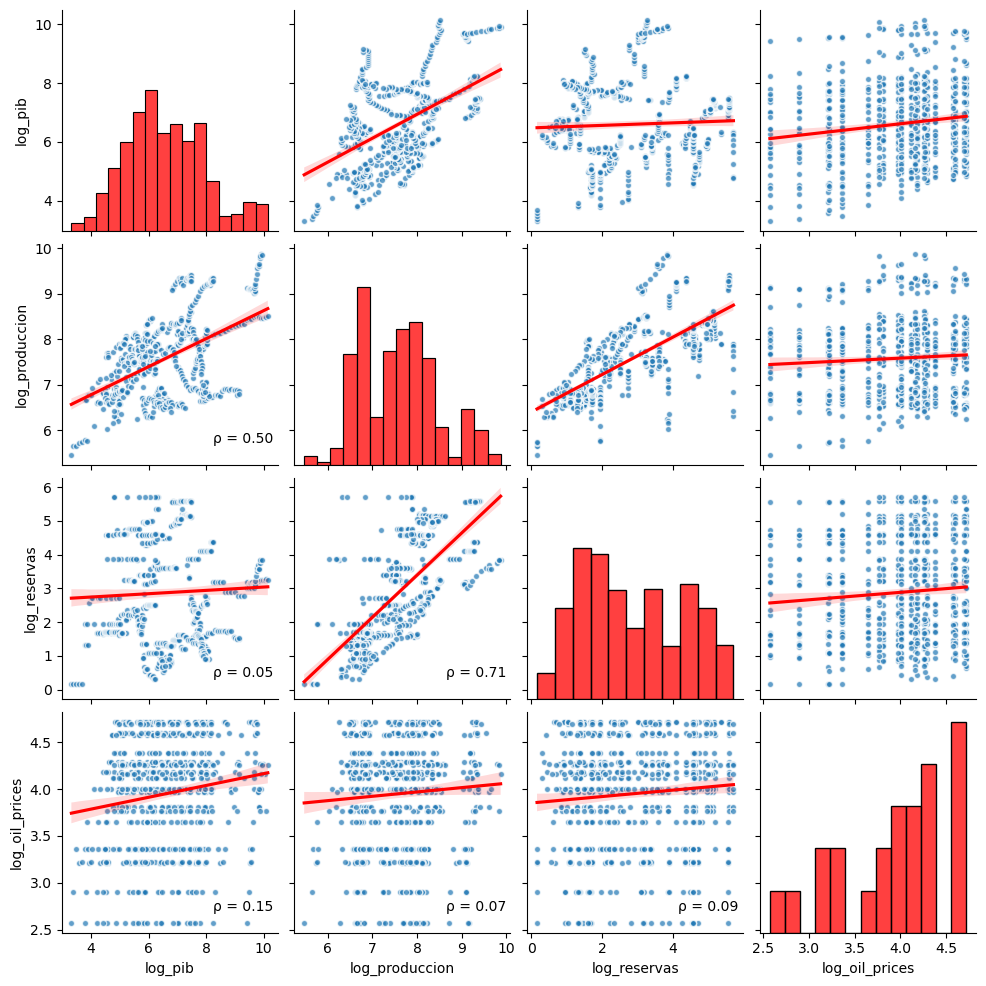

In [11]:
g = sns.pairplot(df[['log_pib', 'log_produccion', 'log_reservas', 'log_oil_prices']], kind = "reg", diag_kind='hist', diag_kws = {'color': 'red'}, plot_kws={'line_kws':{'color':'red'}, 'scatter_kws':{"alpha": 0.7, "s": 20, 'edgecolors': 'white'}})
g.map_lower(corrfunc)
plt.show()

###  3.a  La producción de petroleo se ve afectada fuertemente por las reservas disponibles

### 3.b Ahí están 

### 3.c Más o menos

### 4. Scatter plots

In [12]:
def plot_relations(data: pd.DataFrame, title:str, x:str, y:str):
    fig, ax =plt.subplots(2,2, figsize=(15,8), sharex = False)
    count = 1
    for i in range(len(ax)):
        for j in range(len(ax[i])):
            sns.regplot(data = data, x = x, y = y, scatter_kws={"alpha": 0.7, "s": 20, 'edgecolors': 'white'}, line_kws = {"color": "red"}, ax = ax[i,j], order = count )
            ax[i,j].set_title(f'{title} con ajuste de orden {count}')
            count+=1
    fig.subplots_adjust(wspace=0.3, hspace = 0.3)
    fig.show()


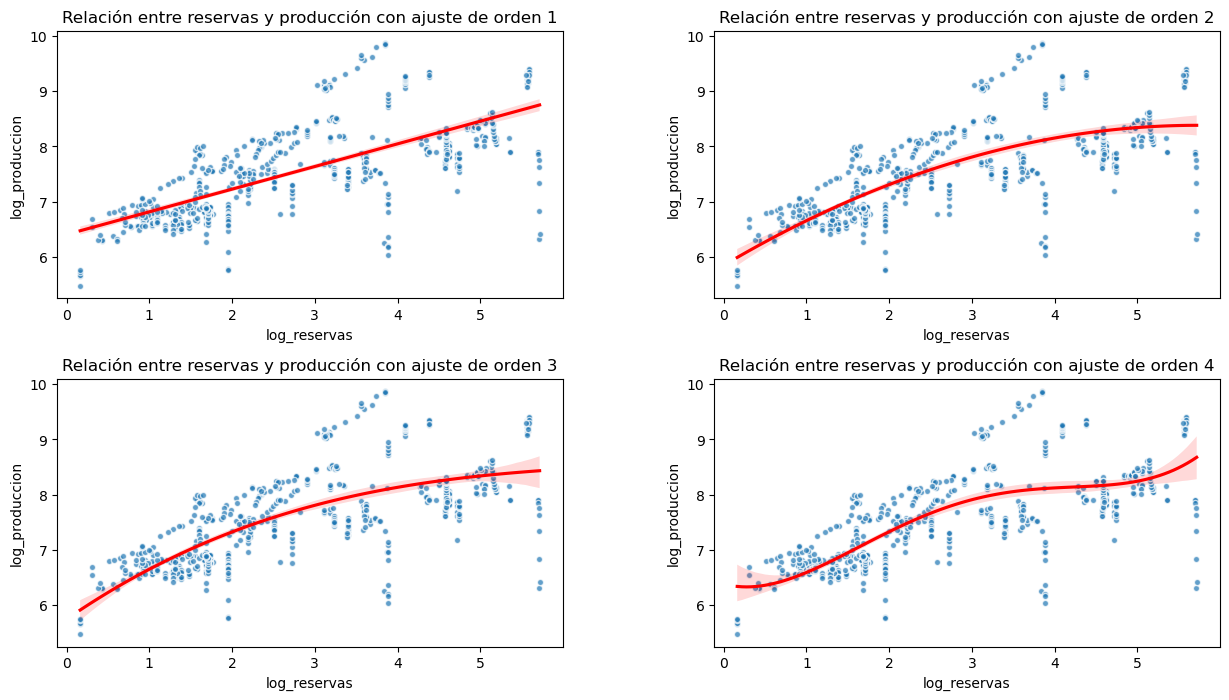

In [13]:
plot_relations(df, 'Relación entre reservas y producción', 'log_reservas', 'log_produccion')

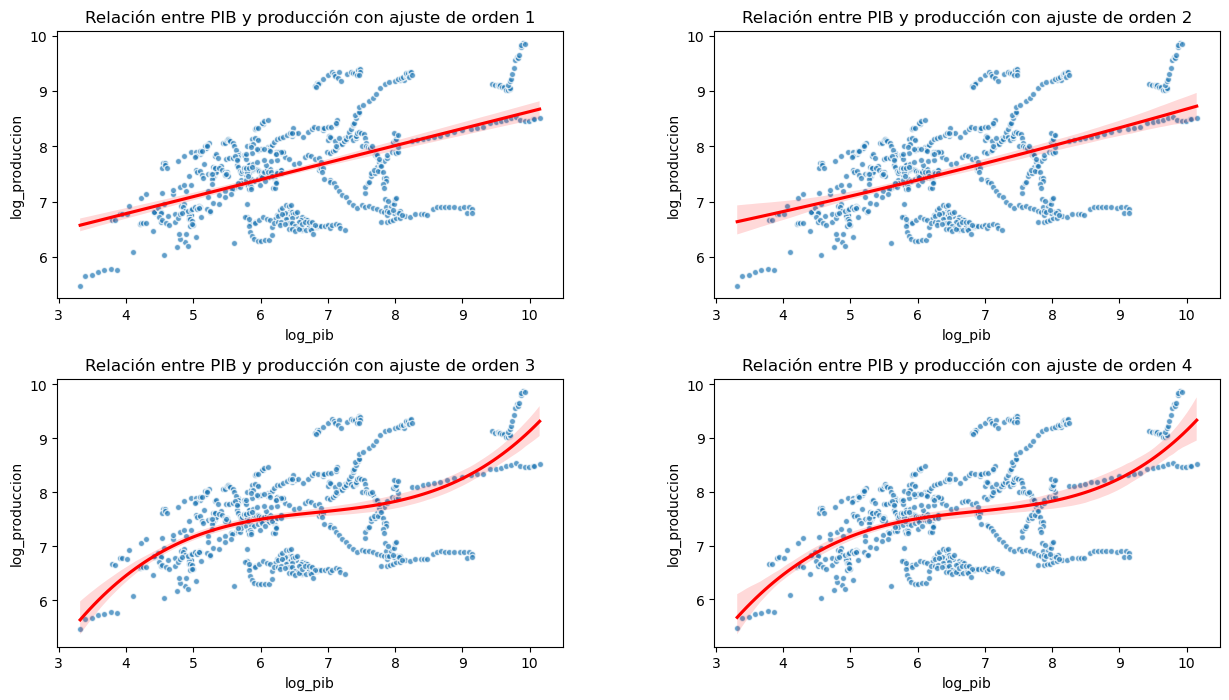

In [14]:
plot_relations(df, 'Relación entre PIB y producción', 'log_pib', 'log_produccion')

### 5. Boxplot

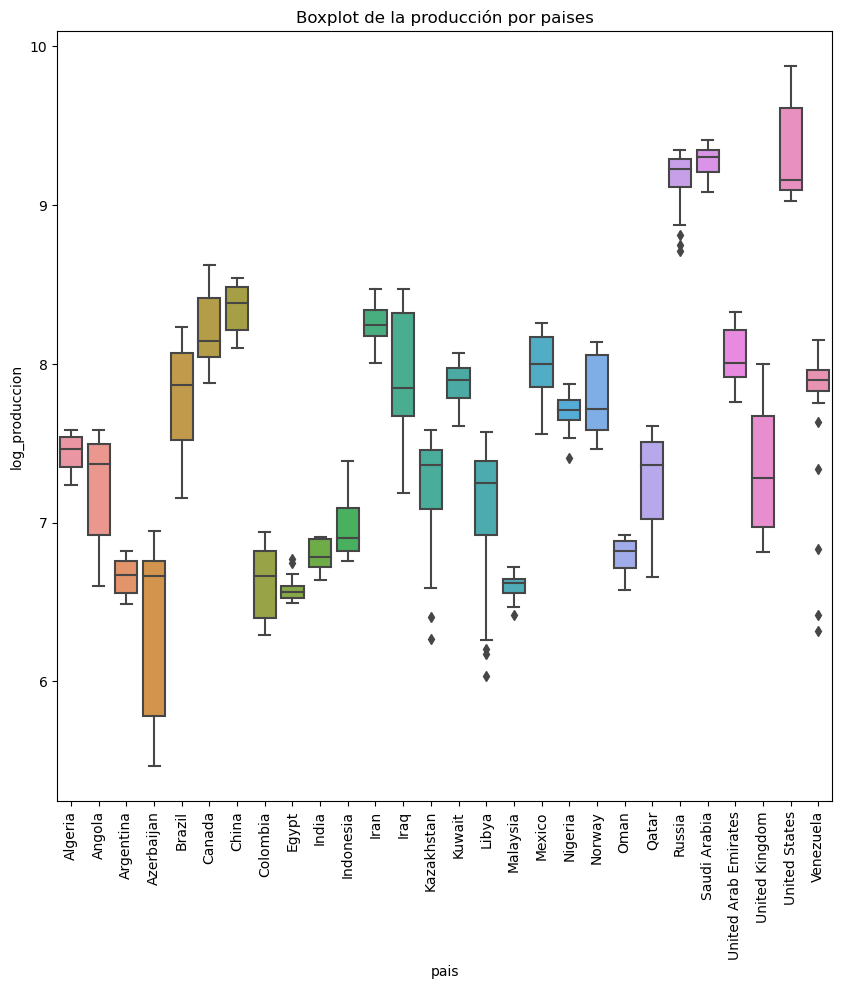

In [15]:
plt.figure(figsize = (10,10))
sns.boxplot(data = df, x = 'pais', y = 'log_produccion')
plt.xticks(rotation = 90)
plt.title('Boxplot de la producción por paises')
plt.show()

### 6. Model Estimation

$$
y_{it} = \alpha_0 + \beta_{1}R_{it-1} + \beta_{2}R_{it-1}^{2} + \beta_{3}PIB_{it} + \beta_{4}OIL_{it} + \varepsilon_{it}
$$

In [16]:
#df2 = df.set_index(['year', 'pais'], inplace = True)

In [17]:
df['lag_reserve'] = df['log_reservas'].shift(1)

In [18]:
df['lag_resq'] = np.square(df['lag_reserve'])

In [19]:
df.columns

Index(['year', 'Produccion ', 'Reservas', 'PIB', 'Oil Prices', 'pais',
       'log_produccion', 'log_reservas', 'log_pib', 'log_oil_prices',
       'lag_reserve', 'lag_resq'],
      dtype='object')

In [20]:
import statsmodels.api as sm

In [21]:
X1 = sm.add_constant(df[['lag_reserve', 'lag_resq', 'log_pib', 'log_oil_prices']])
Y = df["log_produccion"]

model1 = sm.OLS(Y, X1, missing = 'drop').fit() #ESTIMAR EL MODELO
print(model1.summary()) #OUPUT DE LOS PRINCIPALES RESULTADOS

                            OLS Regression Results                            
Dep. Variable:         log_produccion   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     432.2
Date:                Thu, 16 Feb 2023   Prob (F-statistic):          1.96e-183
Time:                        13:04:40   Log-Likelihood:                -411.22
No. Observations:                 671   AIC:                             832.4
Df Residuals:                     666   BIC:                             855.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.4731      0.150     29.

$$
y_{it} = \alpha_0 + \beta_{1}R_{it-1} + \beta_{2}R_{it-1}^{2} + \beta_{3}PIB_{it} + \beta_{4}OIL_{it} + \sum_{j=1}^{27}\gamma_{j}g_{j} +  \varepsilon_{it}
$$

In [24]:
model2= sm.formula.ols('log_produccion ~ C(pais) + lag_reserve + lag_resq  + log_pib + log_oil_prices', data=df).fit()
print(model2.summary()) #OUPUT DE LOS PRINCIPALES RESULTADOS

                            OLS Regression Results                            
Dep. Variable:         log_produccion   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     382.4
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:04:40   Log-Likelihood:                 156.88
No. Observations:                 671   AIC:                            -249.8
Df Residuals:                     639   BIC:                            -105.5
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 